In [468]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from skimage import io
import scipy.io as sio
import torch
from torch import nn
import torch.utils.data
from torchvision.transforms import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image
cv.__version__

'3.4.2'

In [469]:
torch.cuda.is_available()

False

### Face region

In [470]:
def detect_face_helper(image):
    face_cascade = cv.CascadeClassifier("/home/yige/anaconda3/share/OpenCV/haarcascades/haarcascade_frontalface_alt.xml")
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    return faces

In [471]:

top_left_x = int(nose[0] - (mouth[1] - left_eye[1]))
top_left_y = int((mouth[1] + right_eye[1])/2 - (mouth[1] - left_eye[1]))
top_right_x = int(nose[0] + (mouth[1] - left_eye[1]))
top_right_y = int((mouth[1] + right_eye[1])/2 + (mouth[1] - left_eye[1]))
top_left_x,top_right_x

(80, 165)

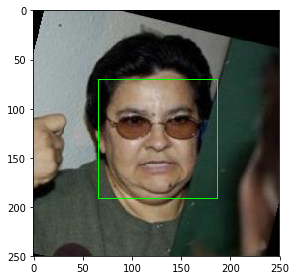

In [472]:
pic = cv.imread("./project1/train_data/female/image_001.jpg")
faces = detect_face_helper(pic)
RGB_img = cv.cvtColor(pic, cv.COLOR_BGR2RGB)
bound = max(faces[0][2], faces[0][3])
x,y = faces[0][0], faces[0][1]
img1  = cv.rectangle(RGB_img, (x,y),(x+bound,y+bound),(0,255,0),1)
io.imshow(img1)

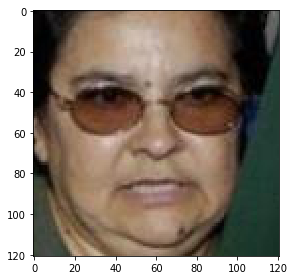

In [473]:
pic = cv.imread("./project1/train_data/female/image_001.jpg")
RGB_img = cv.cvtColor(pic, cv.COLOR_BGR2RGB)
RGB_img = RGB_img[y:y+bound, x:x+bound]
io.imshow(RGB_img)

In [474]:
male_dir = "./project1/train_data/male/"
female_dir = "./project1/train_data/female/"
male_out = "./train/male/"
female_out = "./train/female/"
all_data = []
for i in range(1,261):# image_001 to image_260
    index = ""
    if i < 10:
        index = "00" + str(i)
    elif i< 100:
        index = "0" + str(i)
    else:
        index = str(i)
    image_male = cv.imread(male_dir + "image_" + index + ".jpg")
    faces = detect_face_helper(image_male)
    if len(faces) == 1:
        RGB_img = cv.cvtColor(image_male, cv.COLOR_BGR2RGB)
        bound = max(faces[0][2], faces[0][3])
        x,y = faces[0][0], faces[0][1]
        male_face = RGB_img[y:y+bound, x:x+bound, :]
        io.imsave(male_out+str(i)+".jpg", male_face)
    
    image_female = cv.imread(female_dir + "image_" + index + ".jpg")
    faces = detect_face_helper(image_female)
    if len(faces) == 1:
        RGB_img = cv.cvtColor(image_female, cv.COLOR_BGR2RGB)
        bound = max(faces[0][2], faces[0][3])
        x,y = faces[0][0], faces[0][1]
        female_face = RGB_img[y:y+bound, x:x+bound, :]
        all_data.append(((female_face), 1))
        io.imsave(female_out+str(i)+".jpg", female_face)

    
len(all_data)

249

### classifier

In [475]:
# define our dataset
class faceDataset(torch.utils.data.Dataset):
    def __init__(self, dataList, transform=None):
        super(faceDataset, self).__init__()
        self.datas = dataList
        self.transform = transform
        self.len = len(dataList)
    
    def __getitem__(self, index):
        img, label = self.datas[index]
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, label
    
    def __len__(self):
        return self.len

In [476]:
# define our transformation function
train_trans = transforms.Compose([
    transforms.Resize((227,227)),
    #data augmentation,
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [387]:
# load data
train_data = datasets.ImageFolder(root='./train', transform=train_trans)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=4)
test_data = datasets.ImageFolder(root='./train', transform=train_trans)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False, num_workers=4)

In [478]:
# create model - AlexNet
class simpleAlex(nn.Module):
    def __init__(self, num_classes = 2):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96,kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384,kernel_size=3,padding=1),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384,kernel_size=3,padding=1),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        # fully connected layer
        self.layer6 = nn.Sequential(
            nn.Linear(in_features=9216, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        self.layer7 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        self.layer8 = nn.Linear(in_features=4096, out_features=num_classes)
        
    def forward(self, train):
        output = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(train)))))
        # flattern
        output = output.view(-1, 9216)
        output = self.layer8(self.layer7(self.layer6(output)))
        return output

In [479]:
model = simpleAlex(2)

if torch.cuda.is_available():
    model.cuda()

optimizer = Adam(params=model.parameters(),lr=1e-6)
loss_func = nn.CrossEntropyLoss()

In [391]:
def save_models(epoch):
    torch.save(model.state_dict(), "./models/gender_classifier_{}.model".format(epoch))
    print("checkpoint")

def adjust_lr(epoch, lr=0.0001):
    if epoch > 120:
        lr = lr/1000000
    elif epoch > 100:
        lr = lr/100000
    elif epoch > 80:
        lr = lr/10000
    elif epoch > 60:
        lr = lr/1000
    elif epoch > 40:
        lr = lr/100
    elif epoch > 20:
        lr = lr/10
    
    for params in optimizer.param_groups:
        print("learning rate: {}".format(lr))
        params["lr"] = lr


def test():
    model.eval()
    correct = 0
    total = 0
    for data in test_loader:
            t_img, t_label = data
            t_img = t_img.cuda()
            t_label = t_label.cuda()
            outputs = model(t_img)
            _,predicted = torch.max(outputs.data, 1)
            total += t_label.size(0)
            correct += (predicted == t_label).sum().item()
    return correct/total

def test_train():
    model.eval()
    correct = 0
    total = 0
    for data in train_loader:
            t_img, t_label = data
            t_img = t_img.cuda()
            t_label = t_label.cuda()
            outputs = model(t_img)
            _,predicted = torch.max(outputs.data, 1)
            total += t_label.size(0)
            correct += (predicted == t_label).sum().item()
    return correct/total  

def train(epoches):
    best_acc = 0.0
    
    for epoch in range(epoches):
        model.train()
        correct = 0
        running_loss = 0.0
        total = 0
        print("===================")
        for idx, (images, labels) in enumerate(train_loader, 0):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        running_loss /= len(train_data)

        
        adjust_lr(epoch)
        
        
        train_acc =test_train()
        test_acc = test()
        if test_acc > best_acc or test_acc > 0.98:
            save_models(epoch, test_acc)
            best_acc = test_acc
        print("epoch {}, test accuarcy {}, training loss {}, train accuarcy {}".format(epoch, test_acc, running_loss, train_acc))
        
        

In [466]:
train(0)

### load model and test

In [439]:
device = torch.device('cpu')
checkpoint = torch.load("./models/gender_classifier_18_97.model",map_location=device)
simpleA_net = simpleAlex(num_classes=2)
simpleA_net.load_state_dict(checkpoint)
simpleA_net.eval()

simpleAlex(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (layer5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer6): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(in

In [463]:
def predict_gender(pic):
    transformation = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(227),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image_tensor = transformation(pic).float()
    image_tensor = image_tensor.unsqueeze_(0)
    if torch.cuda.is_available():
        image_tensor.cuda()
    output = simpleA_net(image_tensor)
    _,predicted = torch.max(output.data, 1)
    if int(predicted) == 0:
        return 'female'
    else:
        return 'male'
    

In [465]:
pic = cv.imread('./train/female/4.jpg')
pic = cv.cvtColor(pic, cv.COLOR_BGR2RGB)
print(predict_gender(pic))

female


In [483]:
result=[]
for i in range(1,4):
    pic = cv.imread('./train/female/'+str(i)+".jpg")
    pic = cv.cvtColor(pic, cv.COLOR_BGR2RGB)
    result.append(predict_gender(pic))
    pic = cv.imread('./train/male/'+str(i)+".jpg")
    pic = cv.cvtColor(pic, cv.COLOR_BGR2RGB)
    result.append(predict_gender(pic))

In [484]:
result

['male', 'male', 'female', 'male', 'female', 'male']